In [2]:
import sys
sys.path.append("/p300s/wangmx_group/xutingfeng/SIS/")


In [3]:

from sis.dataset import SISDataset
import torch 
import transformers 
from sis.model.sismodel import DoubleTransformerModel
from sis.utils import modelParametersNum, try_gpu

# Step1 dataset load 
# device = try_gpu()
device = "cuda:1"

sisdataset = SISDataset(root_dir="/p300s/wangmx_group/xutingfeng/SIS/sis/dataset/total_data.csv", device = device)

aa_vocab = sisdataset.aa_vocab
sis_datasetDict = sisdataset.dataset_dict

train_dataloader = torch.utils.data.DataLoader(sis_datasetDict["train"], batch_size=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(sis_datasetDict["test"], batch_size=4, shuffle=True)




Using custom data configuration default-52200760334198e7
Reusing dataset csv (/home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-bec2fd355b0cb7d7.arrow


Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-0f1986b4010acd7d.arrow


Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-d7b3eee632703ea9.arrow


Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-fbd879c251d0f77b.arrow
Loading cached split indices for dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f445a5304f7ba125.arrow and /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-cfda44d28db5f2dc.arrow


In [5]:
aa_vocab

Vocab()

In [4]:
from sis.train import train
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
import os.path as osp
import os 

# Step2 build model
N = 2
d_model = len(aa_vocab)
d_ff = 256
dropout = 0.3
length = sisdataset.SLF_max_length + sisdataset.SRnase_max_length

model = DoubleTransformerModel(N = N, d_model=d_model,d_ff=d_ff, dropout=dropout, seq_length=length) 

# Step3定义 optim and loss
optim = torch.optim.Adam(model.parameters(), lr=4e-3)
loss = nn.CrossEntropyLoss()
print(modelParametersNum(model))
## log path and save path
model_name = model.__class__.__name__
log_path = f"/p300s/wangmx_group/xutingfeng/SIS/output/logs/{model_name}"

summaryWriter = SummaryWriter(log_path)  # 使用tensorboard记录loss

save_path = f"/p300s/wangmx_group/xutingfeng/SIS/output/model"
# Step4 train
train(net = model, train_dataIter= train_dataloader, test_dataIter= test_dataloader,loss=loss, optim=optim, summary_writer = summaryWriter, epochs=100, device=device,
 savemodel=False, 
#  save_path = save_path
 )



模型总参数个数：55378
55378
epoch 10 : train: mean loss/per 0.813 acc is 0.847 and time is 128.15265801454058review/per sec
test: loss 1.589 and acc is 0.667
epoch 20 : train: mean loss/per 0.813 acc is 0.847 and time is 130.79924754365499review/per sec
test: loss 1.733 and acc is 0.667
epoch 30 : train: mean loss/per 0.813 acc is 0.847 and time is 128.58195059447291review/per sec
test: loss 1.661 and acc is 0.667
epoch 40 : train: mean loss/per 0.832 acc is 0.847 and time is 130.7074314966835review/per sec
test: loss 1.589 and acc is 0.667
epoch 50 : train: mean loss/per 0.832 acc is 0.847 and time is 124.6750725865812review/per sec
test: loss 1.589 and acc is 0.667
epoch 60 : train: mean loss/per 0.813 acc is 0.847 and time is 129.04386514280588review/per sec
test: loss 1.661 and acc is 0.667
epoch 70 : train: mean loss/per 0.793 acc is 0.847 and time is 132.56028407925206review/per sec
test: loss 1.733 and acc is 0.667
epoch 80 : train: mean loss/per 0.813 acc is 0.847 and time is 144.67192

In [4]:
from sis.train import test, predict

test(model, test_dataloader, loss)

(1.6639447212219238, 0.7333333333333333)

In [9]:
from itertools import chain
import pandas as pd 

iter_dataloader = train_dataloader

o = predict(iter_dataloader, model).cpu()
label = torch.concat([i["label"] for i in iter_dataloader]).cpu()

def flatten_list(x:list):
    return list(chain.from_iterable(x))
names = flatten_list([zip(i["SLF"], i["SRnase"]) for i in iter_dataloader])

pred = (o>0.5).int().flatten()


pd.DataFrame({"names":names, "pred":pred, "label":label})

,names,pred,label
0,"(S9-SLF1, S19-RNase)",1,0
1,"(S7-SLF1, S17-RNase)",1,0
2,"(S11-SLF2, S9-RNase)",1,1
3,"(S11-SLF2, S5-RNase)",1,1
4,"(S11-SLF3, S19-RNase)",0,0
5,"(S7-SLF3, S5-RNase)",0,0
6,"(S5-SLF1, S9-RNase)",1,0
7,"(S11-SLF1, S5-RNase)",0,0
8,"(S7-SLF2, S11-RNase)",0,0
9,"(S5-SLF2, S11-RNase)",1,1


In [10]:
from itertools import chain
import pandas as pd 

iter_dataloader = test_dataloader

o = predict(iter_dataloader, model)
label = torch.concat([i["label"] for i in iter_dataloader]).cpu()

def flatten_list(x:list):
    return list(chain.from_iterable(x))
names = flatten_list([zip(i["SLF"], i["SRnase"]) for i in iter_dataloader])

pred = (o>0.5).int().flatten()

pd.DataFrame({"names":names, "pred":pred, "label":label})

,names,pred,label
0,"(S7-SLF2, S19-RNase)",1,0
1,"(S7-SLF1, S9-RNase)",0,1
2,"(S9-SLF4, S9-RNase)",0,0
3,"(S11-SLF1, S11-RNase)",1,1
4,"(S5-SLF2, S9-RNase)",1,1
5,"(S5-SLF1, S5-RNase)",0,0
6,"(S9-SLF10, S9-RNase)",0,0
7,"(S5-SLF1, S17-RNase)",1,1
8,"(S7-SLF3, S11-RNase)",1,0
9,"(S11-SLF2, S7-RNase)",1,1


In [11]:
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np 


def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax



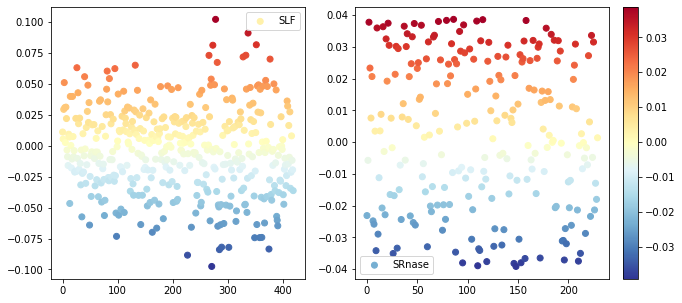

In [12]:
# show 最后一层的w

w = model.fc2.weight.flatten().cpu().detach().numpy()

cmap1 = cm.RdYlBu_r

w_SLF = w[:sisdataset.SLF_max_length]
w_SRnase = w[-sisdataset.SRnase_max_length:]

fig, axes = plt.subplots(1, 2,figsize=(10, 5))

axes[0].scatter(range(0, sisdataset.SLF_max_length), w_SLF, label="SLF", c=w_SLF,cmap= cmap1)
axes[0].legend()

im = axes[1].scatter(range(0, sisdataset.SRnase_max_length), w_SRnase, label="SRnase", c=w_SRnase, cmap = cmap1)
axes[1].legend()

cax = add_right_cax(axes[1], pad=0.02, width=0.02)
cbar = fig.colorbar(im, cax=cax)

plt.show()

In [13]:
# extract score paired with SLF_Seq and SRnase_Seq

score_tuple = []

for x in train_dataloader:
    o = model(x, return_scores=True)

    SLF_Seq = list(map(aa_vocab.lookup_tokens, x["SLF_Seq_token"].cpu().detach().numpy().tolist()))
    SRnase_Seq = list(map(aa_vocab.lookup_tokens, x["SRnase_Seq_token"].cpu().detach().numpy().tolist()))
    scores = model.scores.cpu().detach().numpy()
    [score_tuple.append([SLF_seq, SRnase_seq, score]) for SLF_seq, SRnase_seq, score in zip(SLF_Seq, SRnase_Seq, scores)]
    



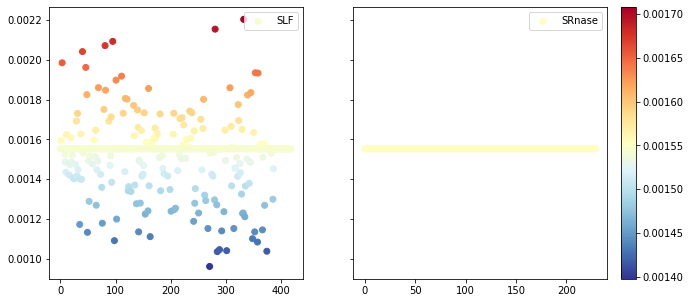

In [39]:
import torch.nn.functional as F 

idx = 22

cmap1 = cm.RdYlBu_r

SLF_seq, SRnase_seq, score = score_tuple[idx]

# calculate score * w 
w = model.fc2.weight.flatten().cpu().detach().numpy()
score = score * w

score = F.softmax(torch.tensor(score),dim=-1).numpy()

SLF_seq_length = len(SLF_seq)
SRnase_seq_length = len(SRnase_seq)

score_SLF = score[:SLF_seq_length]
score_SRnase = score[-SRnase_seq_length:]

fig, axes = plt.subplots(1, 2,figsize=(10, 5),sharey=True)

axes[0].scatter(range(0, SLF_seq_length), score_SLF, label="SLF", c=score_SLF,cmap= cmap1)
axes[0].legend()

im = axes[1].scatter(range(0, SRnase_seq_length), score_SRnase, label="SRnase", c=score_SRnase, cmap = cmap1)
axes[1].legend()

cax = add_right_cax(axes[1], pad=0.02, width=0.02)
cbar = fig.colorbar(im, cax=cax)

plt.show()


(650,)